Load NeSO model

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.integrate import cumulative_trapezoid
from tqdm import tqdm
import matplotlib.pyplot as plt

############################################
# Common Drift Generation Function
############################################
def generate_drift(T_vals, T):
    """
    Generates a drift function u(t) using either a single sine wave
    or a sum of two sine waves with equal probability.
    """
    if np.random.rand() < 0.5:
        # Single sine wave
        A = np.random.uniform(-1, 1)
        freq = np.random.uniform(0.5, 2)
        phi = np.random.uniform(0, 2*np.pi)
        u = A * np.sin(2*np.pi * freq * T_vals/T + phi)
    else:
        # Sum of two sine waves
        A1 = np.random.uniform(-1, 1)
        freq1 = np.random.uniform(0.5, 2)
        phi1 = np.random.uniform(0, 2*np.pi)
        A2 = np.random.uniform(-1, 1)
        freq2 = np.random.uniform(0.5, 2)
        phi2 = np.random.uniform(0, 2*np.pi)
        u = A1 * np.sin(2*np.pi * freq1 * T_vals/T + phi1) + \
            A2 * np.sin(2*np.pi * freq2 * T_vals/T + phi2)
    return u

############################################
# Neural Operator Components
############################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Fourier modes along t dimension
        self.modes2 = modes2  # Fourier modes along x dimension
        self.scale = 1 / (in_channels * out_channels)
        # Learned complex weights
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        # input: (batch, in_channels, t, x)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier transform
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1,
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(
            x_ft[:, :, :self.modes1, :self.modes2], self.weights)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class NeuralOperatorControlPointNet(nn.Module):
    def __init__(self, modes1, modes2, width, n_cp_t, n_cp_x, n_layers=4):
        super(NeuralOperatorControlPointNet, self).__init__()
        self.n_cp_t = n_cp_t
        self.n_cp_x = n_cp_x
        # Lifting: from 1 channel to width channels
        self.fc0 = nn.Linear(1, width)
        # Fourier layers: alternating spectral conv and 1x1 conv
        self.conv_layers = nn.ModuleList()
        for _ in range(n_layers):
            self.conv_layers.append(SpectralConv2d(width, width, modes1, modes2))
            self.conv_layers.append(nn.Conv2d(width, width, 1))
        # Final projection layers to output the inner control points (flattened)
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, (n_cp_t - 1) * (n_cp_x - 1))

    def forward(self, x):
        # x shape: (batch, 1, grid_t, grid_x)
        x = x.permute(0, 2, 3, 1)   # (batch, grid_t, grid_x, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)    # (batch, width, grid_t, grid_x)
        for i in range(0, len(self.conv_layers), 2):
            x1 = self.conv_layers[i](x)
            x2 = self.conv_layers[i+1](x)
            x = torch.relu(x1 + x2)
        # Global average pooling
        x = x.mean(dim=[2,3])
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(x.shape[0], self.n_cp_t - 1, self.n_cp_x - 1)
        return x

############################################
# B-spline Basis Functions
############################################
def BsFun(i, d, t, Ln):
    if d == 0:
        return 1.0 if Ln[i - 1] <= t < Ln[i] else 0.0
    else:
        a = 0 if (Ln[d+i-1]-Ln[i-1])==0 else (t - Ln[i-1])/(Ln[d+i-1]-Ln[i-1])
        b = 0 if (Ln[d+i]-Ln[i])==0 else (Ln[d+i]-t)/(Ln[d+i]-Ln[i])
        return a * BsFun(i, d-1, t, Ln) + b * BsFun(i+1, d-1, t, Ln)

def BsFun_derivative(i, d, t, Ln):
    if d==0:
        return 0.0
    else:
        a = 0 if (Ln[d+i-1]-Ln[i-1])==0 else d/(Ln[d+i-1]-Ln[i-1])
        b = 0 if (Ln[d+i]-Ln[i])==0 else d/(Ln[d+i]-Ln[i])
        return a * BsFun(i, d-1, t, Ln) - b * BsFun(i+1, d-1, t, Ln)

def BsFun_second_derivative(i, d, t, Ln):
    if d < 2:
        return 0.0
    else:
        a = 0 if (Ln[d+i-2]-Ln[i-2])==0 else d*(d-1)/((Ln[d+i-2]-Ln[i-2])**2)
        b = 0 if (Ln[d+i-1]-Ln[i-1])==0 else 2*d*(d-1)/((Ln[d+i-1]-Ln[i-1])**2)
        c = 0 if (Ln[d+i]-Ln[i])==0 else d*(d-1)/((Ln[d+i]-Ln[i])**2)
        return a*BsFun(i, d-2, t, Ln) - b*BsFun(i+1, d-2, t, Ln) + c*BsFun(i+2, d-2, t, Ln)

def BsKnots(n_cp, d, Ns):
    n_knots = n_cp + d + 1
    Ln = np.zeros(n_knots)
    for i in range(d+1, n_knots-d):
        Ln[i] = i - d
    Ln[n_knots-d:] = n_cp - d
    tk = np.linspace(0, Ln[-1], Ns)
    Bit = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit[i, j] = BsFun(j+1, d, tk[i], Ln)
    Bit[-1, n_cp-1] = 1
    return tk, Ln, Bit

def BsKnots_derivatives(n_cp, d, Ns, Ln, tk):
    Bit_deriv = np.zeros((Ns, n_cp))
    Bit_sec_deriv = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit_deriv[i,j] = BsFun_derivative(j+1, d, tk[i], Ln)
            Bit_sec_deriv[i,j] = BsFun_second_derivative(j+1, d, tk[i], Ln)
    return Bit_deriv, Bit_sec_deriv

def compute_bspline_derivatives(U_full, Bit_t, Bit_x, Bit_t_deriv, Bit_x_deriv, Bit_t_sec_deriv, Bit_x_sec_deriv):
    B_surface_t = torch.matmul(torch.matmul(Bit_t_deriv, U_full), Bit_x.T)
    B_surface_x = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x_deriv.T)
    B_surface_xx = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x_sec_deriv.T)
    return B_surface_t, B_surface_x, B_surface_xx

############################################
# Ground Truth Calculation with Refined Time Grid
############################################
def ground_truth(x_vals, T_vals, a, u):
    """
    Computes the hitting time probability for dynamics:
         dx_t = u(t) dt + dW_t,
    where u is a numpy array on the time grid T_vals.

    f(x,t) = (a-x)/sqrt(2*pi*t^3) * exp(-(((a-x)-U(t))^2)/(2*t)), with U(t)=∫₀ᵗ u(s) ds.
    F(x,T) is obtained by cumulative integration over T_vals.
    For x >= a, F(x,T)=1.
    """
    # Compute cumulative drift U(t)
    U = cumulative_trapezoid(u, T_vals, initial=0)
    # Create grids
    T_grid, X_grid = np.meshgrid(T_vals, x_vals, indexing='ij')
    U_grid = U[:, None]
    eps = 1e-8
    T_grid_mod = np.where(T_grid < eps, eps, T_grid)
    f = (a - X_grid) / np.sqrt(2 * np.pi * T_grid_mod**3) * \
        np.exp(-(((a - X_grid) - U_grid)**2)/(2*T_grid_mod))
    f[0, :] = 0
    F = cumulative_trapezoid(f, T_vals, axis=0, initial=0)
    # Force F = 1 for x >= a
    ix = np.where(x_vals >= a)[0]
    F[:, ix] = 1.0
    return F

############################################
# Setup: Grids, Data Generation, and B-spline Bases
############################################
T = 10           # maximum time
a = 4.0          # fixed barrier
n_cp_t = 25      # control points in time
n_cp_x = 25      # control points in space
d = 3            # B-spline order

# Refined time grid (dense near t=0)
T_vals = np.linspace(1e-4, T, 1001)  # 1001 points from 1e-4 to T
Nt = len(T_vals)

# Spatial grid
x_vals = np.linspace(-10, a, 101)      # 101 points from -10 to a
Nx = len(x_vals)

modes1 = 8
modes2 = 8
width = 32

# B-spline bases for time (shared across samples)
tk_t, Ln_t, Bit_t_np = BsKnots(n_cp_t, d, Nt)
Bit_t_deriv_np, Bit_t_sec_deriv_np = BsKnots_derivatives(n_cp_t, d, Nt, Ln_t, tk_t)
Bit_t = torch.tensor(Bit_t_np, dtype=torch.float32)
Bit_t_deriv = torch.tensor(Bit_t_deriv_np, dtype=torch.float32)
Bit_t_sec_deriv = torch.tensor(Bit_t_sec_deriv_np, dtype=torch.float32)


# Recreate the model architecture
neso_model = NeuralOperatorControlPointNet(modes1, modes2, width, n_cp_t, n_cp_x, n_layers=3)

# Define the save path on Google Drive (adjust as needed)
neso_save_path = '/content/drive/MyDrive/FNO/Trained Models/bspline_small_10_sample_500_epoch.pth'

# Load the model state dictionary
neso_model.load_state_dict(torch.load(neso_save_path))
neso_model.eval()  # Set to evaluation mode

print("Model loaded from", neso_save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded from /content/drive/MyDrive/FNO/Trained Models/bspline_small_10_sample_500_epoch.pth


Load FNO model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.integrate import cumulative_trapezoid
from tqdm import tqdm

#############################
# Spectral Convolution Layer
#############################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Fourier modes along time dimension
        self.modes2 = modes2  # Fourier modes along space dimension
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat)
        )

    def compl_mul2d(self, input, weights):
        # Performs complex multiplication along the Fourier modes.
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier transform
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1,
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(
            x_ft[:, :, :self.modes1, :self.modes2], self.weights)
        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

#############################
# Fourier Neural Operator Model (FNO2d)
#############################
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, n_layers=4):
        """
        The network takes an input of 3 channels:
         - u(t): the control function (broadcast along x)
         - t: time coordinate
         - x: spatial coordinate
        and outputs F_pred(t,x) with one channel.
        """
        super(FNO2d, self).__init__()
        self.width = width
        self.fc0 = nn.Linear(3, width)  # lift input channels to the desired width

        self.conv_layers = nn.ModuleList()
        for _ in range(n_layers):
            self.conv_layers.append(SpectralConv2d(width, width, modes1, modes2))
            self.conv_layers.append(nn.Conv2d(width, width, 1))

        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # x shape: (batch, 3, Nt, Nx)
        batch, channels, Nt, Nx = x.shape
        # Lift input to a higher dimension
        x = x.permute(0, 2, 3, 1)  # (batch, Nt, Nx, 3)
        x = self.fc0(x)           # (batch, Nt, Nx, width)
        x = x.permute(0, 3, 1, 2)  # (batch, width, Nt, Nx)

        # Apply Fourier layers + pointwise convolutions
        for i in range(0, len(self.conv_layers), 2):
            x1 = self.conv_layers[i](x)
            x2 = self.conv_layers[i+1](x)
            x = torch.relu(x1 + x2)

        # Project to the output channel
        x = x.permute(0, 2, 3, 1)  # (batch, Nt, Nx, width)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)           # (batch, Nt, Nx, 1)
        x = x.permute(0, 3, 1, 2)  # (batch, 1, Nt, Nx)
        return x

#############################
# Updated Ground Truth Function
#############################
def ground_truth(x_vals, T_vals, a, u):
    """
    Computes the recovery (hitting time) probability for:
         dx_t = u(t) dt + dW_t,
    with hitting time density
         f(x,t) = (a-x)/sqrt(2*pi*t^3) * exp(-(((a-x)-U(t))^2)/(2*t))
    and then F is obtained by cumulative integration over time.
    To avoid artifacts near the barrier at x = a, we clip the cumulative
    values to [0, 1] and force F(t,x)=1 for x sufficiently close to a.
    """
    # Compute U(t) = ∫₀ᵗ u(s) ds
    U = cumulative_trapezoid(u, T_vals, initial=0)
    T_grid, X_grid = np.meshgrid(T_vals, x_vals, indexing='ij')
    U_grid = U[:, None]
    eps = 1e-8
    T_grid_mod = np.where(T_grid < eps, eps, T_grid)
    f = (a - X_grid) / np.sqrt(2 * np.pi * T_grid_mod**3) * \
        np.exp(-(((a - X_grid) - U_grid)**2) / (2*T_grid_mod))
    # Perform the cumulative integration over time
    F = cumulative_trapezoid(f, T_vals, axis=0, initial=0)
    # Clip to [0, 1] to avoid numerical overshoots
    F = np.clip(F, 0, 1)
    # Force the boundary condition: for x values sufficiently close to a, set F=1.
    tol = 1e-8
    ix = np.where(x_vals >= a - tol)[0]
    F[:, ix] = 1.0
    return F

#############################
# Finite Difference Derivatives
#############################
def compute_fd_derivatives(F, dt, dx):
    """
    Compute finite-difference approximations of the derivatives:
       F_t, F_x, and F_xx for a field F of shape (batch, 1, Nt, Nx).
    """
    batch, ch, Nt, Nx = F.shape

    # Time derivative F_t
    F_t = torch.zeros_like(F)
    F_t[:,:,1:-1,:] = (F[:,:,2:,:] - F[:,:,:-2,:]) / (2*dt)
    F_t[:,:,0,:] = (F[:,:,1,:] - F[:,:,0,:]) / dt
    F_t[:,:,-1,:] = (F[:,:,-1,:] - F[:,:,-2,:]) / dt

    # Spatial derivative F_x
    F_x = torch.zeros_like(F)
    F_x[:,:,:,1:-1] = (F[:,:,:,2:] - F[:,:,:,:-2]) / (2*dx)
    F_x[:,:,:,0] = (F[:,:,:,1] - F[:,:,:,0]) / dx
    F_x[:,:,:,-1] = (F[:,:,:,-1] - F[:,:,:,-2]) / dx

    # Second spatial derivative F_xx
    F_xx = torch.zeros_like(F)
    F_xx[:,:,:,1:-1] = (F[:,:,:,2:] - 2*F[:,:,:,1:-1] + F[:,:,:,:-2]) / (dx**2)
    F_xx[:,:,:,0] = (F[:,:,:,2] - 2*F[:,:,:,1] + F[:,:,:,0]) / (dx**2)
    F_xx[:,:,:,-1] = (F[:,:,:,-1] - 2*F[:,:,:,-2] + F[:,:,:,-3]) / (dx**2)

    return F_t, F_x, F_xx

#############################
# Setup: Grids and Data Generation
#############################
T = 10.0           # maximum time
a = 4.0            # fixed barrier
n_samples = 10     # number of training samples

# Time grid (dense near t=0)
T_vals = np.linspace(1e-4, T, 1001)   # 1001 points
Nt = len(T_vals)
# Spatial grid
x_vals = np.linspace(-10, a, 101)       # 101 points
Nx = len(x_vals)
dt = T_vals[1] - T_vals[0]
dx = x_vals[1] - x_vals[0]


#############################
# Initialize Model and Optimizer
#############################
modes1 = 8
modes2 = 8
width = 32

fno_save_path = '/content/drive/MyDrive/FNO/Trained Models/fno_small_10_sample_500_epoch.pth'

# Reinitialize your model with the same architecture
fno_model = FNO2d(modes1, modes2, width, n_layers=3)
fno_model.load_state_dict(torch.load(fno_save_path, map_location=torch.device('cpu')))
fno_model.eval()
print("Model loaded from", fno_save_path)

Model loaded from /content/drive/MyDrive/FNO/Trained Models/fno_small_10_sample_500_epoch.pth


Prediction

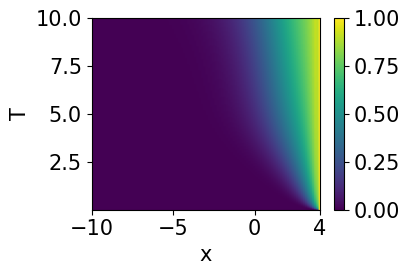

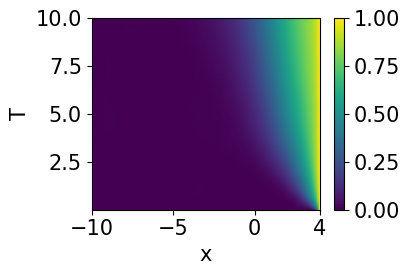

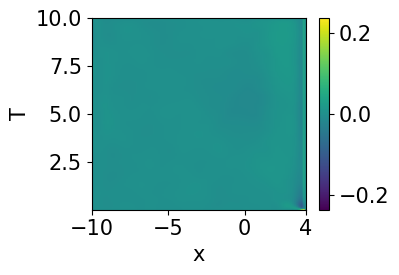

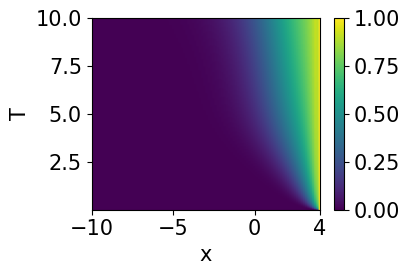

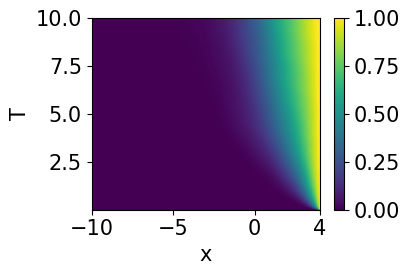

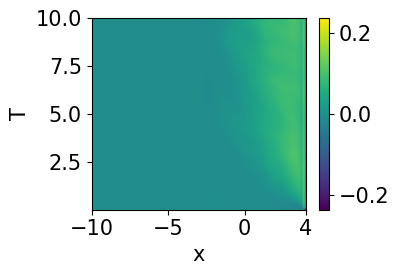

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------
# Assumptions: The following functions are defined:
# - generate_drift(T_vals, T)
# - ground_truth(x_vals, T_vals, a, u)
# - BsKnots(n_cp, d, Ns)
# And the trained models neso_model and fno_model are loaded.
# ---------------------------------------------------

# Set a very large global font size
plt.rcParams.update({'font.size': 15})

# ---------------------------
# Parameters and Grids
# ---------------------------
T = 10.0        # maximum time
a = 4.0         # barrier value
n_cp_t = 25     # number of control points in time
n_cp_x = 25     # number of control points in space
d = 3           # B-spline order

# Define refined time grid and spatial grid
T_vals = np.linspace(1e-4, T, 1001)  # 1001 time points from 1e-4 to T
Nt = len(T_vals)
x_vals = np.linspace(-10, a, 101)      # 101 spatial points from -10 to a
Nx = len(x_vals)

# ---------------------------
# Compute B-spline Bases
# ---------------------------
# Compute B-spline basis for time (shared across samples)
tk_t, Ln_t, Bit_t_np = BsKnots(n_cp_t, d, Nt)
Bit_t = torch.tensor(Bit_t_np, dtype=torch.float32)

# Compute B-spline basis for space
tk_x, Ln_x, Bit_x_np = BsKnots(n_cp_x, d, Nx)
Bit_x = torch.tensor(Bit_x_np, dtype=torch.float32)

# ---------------------------
# Generate a Common Test Sample
# ---------------------------
u_test = generate_drift(T_vals, T)
F_true_test = ground_truth(x_vals, T_vals, a, u_test)  # shape: (Nt, Nx)

# ---------------------------
# Testing with NeSO (Proposed Method)
# ---------------------------
# Prepare input for NeSO (expected shape: (1, 1, Nt, Nx))
F_true_tensor = torch.tensor(F_true_test, dtype=torch.float32)
F_input = F_true_tensor.unsqueeze(0).unsqueeze(0)

neso_model.eval()
with torch.no_grad():
    # Model returns inner control points with shape (n_cp_t-1, n_cp_x-1)
    U_pred = neso_model(F_input)[0]

# Construct full control points with boundary conditions:
# - At t = 0, set all control points to 0.
# - At x = a, set all control points to 1.
U_full = torch.ones((n_cp_t, n_cp_x))
U_full[0, :] = 0
U_full[:, -1] = 1
U_full[1:, :-1] = U_pred

# Compute predicted B-spline surface (hitting probability)
B_surface = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x.T)
F_pred_neso = B_surface.detach().numpy()

# ---------------------------
# Testing with FNO
# ---------------------------
# Prepare input tensor for FNO with shape (1, 3, Nt, Nx)
# Channel 0: u_test broadcast to (Nt, Nx)
u_tensor = torch.tensor(u_test, dtype=torch.float32).unsqueeze(1).repeat(1, Nx)
# Channel 1: time coordinate (Nt, Nx)
t_tensor = torch.tensor(T_vals, dtype=torch.float32).unsqueeze(1).repeat(1, Nx)
# Channel 2: spatial coordinate (Nt, Nx)
x_tensor = torch.tensor(x_vals, dtype=torch.float32).unsqueeze(0).repeat(Nt, 1)
input_tensor = torch.stack([u_tensor, t_tensor, x_tensor], dim=0).unsqueeze(0)

fno_model.eval()
with torch.no_grad():
    F_pred_fno = fno_model(input_tensor).squeeze().cpu().numpy()

# ---------------------------
# Compute Common Error Range for Both Methods
# ---------------------------
error_neso = F_pred_neso - F_true_test
error_fno  = F_pred_fno - F_true_test
E = max(np.abs(error_neso).max(), np.abs(error_fno).max())
error_range = (-E/2, E/2)

# ---------------------------
# Visualization Helper Function
# ---------------------------
def plot_and_save(image, vmin, vmax, filename):
    """
    Plots the given image with fixed color limits and saves the plot as a PDF.
    The plot uses the x-axis from -10 to 4 (ensuring 4 is included) and
    labels the vertical axis as 'T'.
    """
    fig, ax = plt.subplots(figsize=(4, 3))
    im = ax.imshow(image, aspect='auto', origin='lower',
                   extent=[x_vals[0], x_vals[-1], T_vals[0], T_vals[-1]],
                   vmin=vmin, vmax=vmax)
    ax.set_xlabel("x")
    ax.set_ylabel("T")
    ax.set_xlim(x_vals[0], x_vals[-1])
    ax.set_xticks([-10, -5, 0, 4])
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.savefig(filename, format="pdf")
    plt.show()
    plt.close(fig)

# ---------------------------
# Save Individual Plots as PDF Files
# ---------------------------
# For NeSO (Proposed Method)
plot_and_save(F_true_test, 0, 1, "NeSO_GroundTruth.pdf")
plot_and_save(F_pred_neso, 0, 1, "NeSO_Prediction.pdf")
plot_and_save(F_pred_neso - F_true_test, error_range[0], error_range[1], "NeSO_Error.pdf")

# For FNO
plot_and_save(F_true_test, 0, 1, "FNO_GroundTruth.pdf")
plot_and_save(F_pred_fno, 0, 1, "FNO_Prediction.pdf")
plot_and_save(F_pred_fno - F_true_test, error_range[0], error_range[1], "FNO_Error.pdf")


Error Analysis

In [ ]:
import torch
import numpy as np

# ---------------------------
# Parameters and Grids
# ---------------------------
T = 10.0        # maximum time
a = 4.0         # barrier value
n_cp_t = 25     # number of control points in time
n_cp_x = 25     # number of control points in space
d = 3           # B-spline order

# Define refined time grid and spatial grid
T_vals = np.linspace(1e-4, T, 1001)  # 1001 time points from 1e-4 to T
Nt = len(T_vals)
x_vals = np.linspace(-10, a, 101)      # 101 spatial points from -10 to a
Nx = len(x_vals)

# ---------------------------
# Compute B-spline Bases
# ---------------------------
# Compute B-spline basis for time (shared across samples)
tk_t, Ln_t, Bit_t_np = BsKnots(n_cp_t, d, Nt)
Bit_t = torch.tensor(Bit_t_np, dtype=torch.float32)

# Compute B-spline basis for space
tk_x, Ln_x, Bit_x_np = BsKnots(n_cp_x, d, Nx)
Bit_x = torch.tensor(Bit_x_np, dtype=torch.float32)

# ---------------------------
# Containers for Error Metrics
# ---------------------------
neso_mse_list = []
neso_mae_list = []
neso_rel_list = []
fno_mse_list = []
fno_mae_list = []
fno_rel_list = []

num_test_cases = 10

for i in range(num_test_cases):
    # ---------------------------
    # Generate Test Data for Test Case i
    # ---------------------------
    u_test = generate_drift(T_vals, T)
    F_true_test = ground_truth(x_vals, T_vals, a, u_test)  # shape: (Nt, Nx)

    # ---------------------------
    # NeSO Prediction
    # ---------------------------
    F_true_tensor = torch.tensor(F_true_test, dtype=torch.float32)
    F_input = F_true_tensor.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, Nt, Nx)
    neso_model.eval()
    with torch.no_grad():
        # Model returns inner control points with shape (n_cp_t-1, n_cp_x-1)
        U_pred = neso_model(F_input)[0]

    # Construct full control points with boundary conditions:
    # - At t = 0, set all control points to 0.
    # - At x = a, set all control points to 1.
    U_full = torch.ones((n_cp_t, n_cp_x))
    U_full[0, :] = 0
    U_full[:, -1] = 1
    U_full[1:, :-1] = U_pred

    # Compute predicted B-spline surface (hitting probability)
    B_surface = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x.T)
    F_pred_neso = B_surface.detach().numpy()

    # ---------------------------
    # FNO Prediction
    # ---------------------------
    # Prepare input tensor for FNO with shape (1, 3, Nt, Nx)
    # Channel 0: u_test broadcast to (Nt, Nx)
    u_tensor = torch.tensor(u_test, dtype=torch.float32).unsqueeze(1).repeat(1, Nx)
    # Channel 1: time coordinate (Nt, Nx)
    t_tensor = torch.tensor(T_vals, dtype=torch.float32).unsqueeze(1).repeat(1, Nx)
    # Channel 2: spatial coordinate (Nt, Nx)
    x_tensor = torch.tensor(x_vals, dtype=torch.float32).unsqueeze(0).repeat(Nt, 1)
    input_tensor = torch.stack([u_tensor, t_tensor, x_tensor], dim=0).unsqueeze(0)

    fno_model.eval()
    with torch.no_grad():
        F_pred_fno = fno_model(input_tensor).squeeze().cpu().numpy()

    # ---------------------------
    # Compute Errors for Test Case i
    # ---------------------------
    error_neso = F_pred_neso - F_true_test
    error_fno = F_pred_fno - F_true_test

    mse_neso = np.mean(error_neso**2)
    mae_neso = np.mean(np.abs(error_neso))
    # Relative error: using Frobenius norm for 2D arrays
    rel_neso = np.linalg.norm(error_neso) / np.linalg.norm(F_true_test)

    mse_fno = np.mean(error_fno**2)
    mae_fno = np.mean(np.abs(error_fno))
    rel_fno = np.linalg.norm(error_fno) / np.linalg.norm(F_true_test)

    neso_mse_list.append(mse_neso)
    neso_mae_list.append(mae_neso)
    neso_rel_list.append(rel_neso)
    fno_mse_list.append(mse_fno)
    fno_mae_list.append(mae_fno)
    fno_rel_list.append(rel_fno)

# ---------------------------
# Compute and Report Averaged Metrics
# ---------------------------
neso_mse_avg = np.mean(neso_mse_list)
neso_mae_avg = np.mean(neso_mae_list)
neso_rel_avg = np.mean(neso_rel_list)

fno_mse_avg = np.mean(fno_mse_list)
fno_mae_avg = np.mean(fno_mae_list)
fno_rel_avg = np.mean(fno_rel_list)

print("NeSO Metrics (averaged over 10 test cases):")
print("Mean Squared Error:", neso_mse_avg)
print("Mean Absolute Error:", neso_mae_avg)
print("Relative Error:", neso_rel_avg)
print("\nFNO Metrics (averaged over 10 test cases):")
print("Mean Squared Error:", fno_mse_avg)
print("Mean Absolute Error:", fno_mae_avg)
print("Relative Error:", fno_rel_avg)


NeSO Metrics (averaged over 10 test cases):
Mean Squared Error: 0.0002961623971666303
Mean Absolute Error: 0.009139817370241244
Relative Error: 0.05024498434890323

FNO Metrics (averaged over 10 test cases):
Mean Squared Error: 0.004522933220870131
Mean Absolute Error: 0.02664661361309048
Relative Error: 0.16985255356407952


### Ablations with larger networks



Load larger Neso model

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.integrate import cumulative_trapezoid
from tqdm import tqdm
import matplotlib.pyplot as plt

############################################
# Common Drift Generation Function
############################################
def generate_drift(T_vals, T):
    """
    Generates a drift function u(t) using either a single sine wave
    or a sum of two sine waves with equal probability.
    """
    if np.random.rand() < 0.5:
        # Single sine wave
        A = np.random.uniform(-1, 1)
        freq = np.random.uniform(0.5, 2)
        phi = np.random.uniform(0, 2*np.pi)
        u = A * np.sin(2*np.pi * freq * T_vals/T + phi)
    else:
        # Sum of two sine waves
        A1 = np.random.uniform(-1, 1)
        freq1 = np.random.uniform(0.5, 2)
        phi1 = np.random.uniform(0, 2*np.pi)
        A2 = np.random.uniform(-1, 1)
        freq2 = np.random.uniform(0.5, 2)
        phi2 = np.random.uniform(0, 2*np.pi)
        u = A1 * np.sin(2*np.pi * freq1 * T_vals/T + phi1) + \
            A2 * np.sin(2*np.pi * freq2 * T_vals/T + phi2)
    return u

############################################
# Neural Operator Components
############################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Fourier modes along t dimension
        self.modes2 = modes2  # Fourier modes along x dimension
        self.scale = 1 / (in_channels * out_channels)
        # Learned complex weights
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        # input: (batch, in_channels, t, x)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier transform
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1,
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(
            x_ft[:, :, :self.modes1, :self.modes2], self.weights)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class NeuralOperatorControlPointNet(nn.Module):
    def __init__(self, modes1, modes2, width, n_cp_t, n_cp_x, n_layers=4):
        super(NeuralOperatorControlPointNet, self).__init__()
        self.n_cp_t = n_cp_t
        self.n_cp_x = n_cp_x
        # Lifting: from 1 channel to width channels
        self.fc0 = nn.Linear(1, width)
        # Fourier layers: alternating spectral conv and 1x1 conv
        self.conv_layers = nn.ModuleList()
        for _ in range(n_layers):
            self.conv_layers.append(SpectralConv2d(width, width, modes1, modes2))
            self.conv_layers.append(nn.Conv2d(width, width, 1))
        # Final projection layers to output the inner control points (flattened)
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, (n_cp_t - 1) * (n_cp_x - 1))

    def forward(self, x):
        # x shape: (batch, 1, grid_t, grid_x)
        x = x.permute(0, 2, 3, 1)   # (batch, grid_t, grid_x, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)    # (batch, width, grid_t, grid_x)
        for i in range(0, len(self.conv_layers), 2):
            x1 = self.conv_layers[i](x)
            x2 = self.conv_layers[i+1](x)
            x = torch.relu(x1 + x2)
        # Global average pooling
        x = x.mean(dim=[2,3])
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(x.shape[0], self.n_cp_t - 1, self.n_cp_x - 1)
        return x

############################################
# B-spline Basis Functions
############################################
def BsFun(i, d, t, Ln):
    if d == 0:
        return 1.0 if Ln[i - 1] <= t < Ln[i] else 0.0
    else:
        a = 0 if (Ln[d+i-1]-Ln[i-1])==0 else (t - Ln[i-1])/(Ln[d+i-1]-Ln[i-1])
        b = 0 if (Ln[d+i]-Ln[i])==0 else (Ln[d+i]-t)/(Ln[d+i]-Ln[i])
        return a * BsFun(i, d-1, t, Ln) + b * BsFun(i+1, d-1, t, Ln)

def BsFun_derivative(i, d, t, Ln):
    if d==0:
        return 0.0
    else:
        a = 0 if (Ln[d+i-1]-Ln[i-1])==0 else d/(Ln[d+i-1]-Ln[i-1])
        b = 0 if (Ln[d+i]-Ln[i])==0 else d/(Ln[d+i]-Ln[i])
        return a * BsFun(i, d-1, t, Ln) - b * BsFun(i+1, d-1, t, Ln)

def BsFun_second_derivative(i, d, t, Ln):
    if d < 2:
        return 0.0
    else:
        a = 0 if (Ln[d+i-2]-Ln[i-2])==0 else d*(d-1)/((Ln[d+i-2]-Ln[i-2])**2)
        b = 0 if (Ln[d+i-1]-Ln[i-1])==0 else 2*d*(d-1)/((Ln[d+i-1]-Ln[i-1])**2)
        c = 0 if (Ln[d+i]-Ln[i])==0 else d*(d-1)/((Ln[d+i]-Ln[i])**2)
        return a*BsFun(i, d-2, t, Ln) - b*BsFun(i+1, d-2, t, Ln) + c*BsFun(i+2, d-2, t, Ln)

def BsKnots(n_cp, d, Ns):
    n_knots = n_cp + d + 1
    Ln = np.zeros(n_knots)
    for i in range(d+1, n_knots-d):
        Ln[i] = i - d
    Ln[n_knots-d:] = n_cp - d
    tk = np.linspace(0, Ln[-1], Ns)
    Bit = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit[i, j] = BsFun(j+1, d, tk[i], Ln)
    Bit[-1, n_cp-1] = 1
    return tk, Ln, Bit

def BsKnots_derivatives(n_cp, d, Ns, Ln, tk):
    Bit_deriv = np.zeros((Ns, n_cp))
    Bit_sec_deriv = np.zeros((Ns, n_cp))
    for j in range(n_cp):
        for i in range(Ns):
            Bit_deriv[i,j] = BsFun_derivative(j+1, d, tk[i], Ln)
            Bit_sec_deriv[i,j] = BsFun_second_derivative(j+1, d, tk[i], Ln)
    return Bit_deriv, Bit_sec_deriv

def compute_bspline_derivatives(U_full, Bit_t, Bit_x, Bit_t_deriv, Bit_x_deriv, Bit_t_sec_deriv, Bit_x_sec_deriv):
    B_surface_t = torch.matmul(torch.matmul(Bit_t_deriv, U_full), Bit_x.T)
    B_surface_x = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x_deriv.T)
    B_surface_xx = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x_sec_deriv.T)
    return B_surface_t, B_surface_x, B_surface_xx

############################################
# Ground Truth Calculation with Refined Time Grid
############################################
def ground_truth(x_vals, T_vals, a, u):
    """
    Computes the hitting time probability for dynamics:
         dx_t = u(t) dt + dW_t,
    where u is a numpy array on the time grid T_vals.

    f(x,t) = (a-x)/sqrt(2*pi*t^3) * exp(-(((a-x)-U(t))^2)/(2*t)), with U(t)=∫₀ᵗ u(s) ds.
    F(x,T) is obtained by cumulative integration over T_vals.
    For x >= a, F(x,T)=1.
    """
    # Compute cumulative drift U(t)
    U = cumulative_trapezoid(u, T_vals, initial=0)
    # Create grids
    T_grid, X_grid = np.meshgrid(T_vals, x_vals, indexing='ij')
    U_grid = U[:, None]
    eps = 1e-8
    T_grid_mod = np.where(T_grid < eps, eps, T_grid)
    f = (a - X_grid) / np.sqrt(2 * np.pi * T_grid_mod**3) * \
        np.exp(-(((a - X_grid) - U_grid)**2)/(2*T_grid_mod))
    f[0, :] = 0
    F = cumulative_trapezoid(f, T_vals, axis=0, initial=0)
    # Force F = 1 for x >= a
    ix = np.where(x_vals >= a)[0]
    F[:, ix] = 1.0
    return F

############################################
# Setup: Grids, Data Generation, and B-spline Bases
############################################
T = 10           # maximum time
a = 4.0          # fixed barrier
n_cp_t = 25      # control points in time
n_cp_x = 25      # control points in space
d = 3            # B-spline order

# Refined time grid (dense near t=0)
T_vals = np.linspace(1e-4, T, 1001)  # 1001 points from 1e-4 to T
Nt = len(T_vals)

# Spatial grid
x_vals = np.linspace(-10, a, 101)      # 101 points from -10 to a
Nx = len(x_vals)

modes1 = 12
modes2 = 12
width = 64

# B-spline bases for time (shared across samples)
tk_t, Ln_t, Bit_t_np = BsKnots(n_cp_t, d, Nt)
Bit_t_deriv_np, Bit_t_sec_deriv_np = BsKnots_derivatives(n_cp_t, d, Nt, Ln_t, tk_t)
Bit_t = torch.tensor(Bit_t_np, dtype=torch.float32)
Bit_t_deriv = torch.tensor(Bit_t_deriv_np, dtype=torch.float32)
Bit_t_sec_deriv = torch.tensor(Bit_t_sec_deriv_np, dtype=torch.float32)


# Recreate the model architecture
neso_model = NeuralOperatorControlPointNet(modes1, modes2, width, n_cp_t, n_cp_x, n_layers=4)

# Define the save path on Google Drive (adjust as needed)
neso_save_path = '/content/drive/MyDrive/FNO/Trained Models/bspline_10_sample_500_epoch.pth'

# Load the model state dictionary
neso_model.load_state_dict(torch.load(neso_save_path))
neso_model.eval()  # Set to evaluation mode

print("Model loaded from", neso_save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded from /content/drive/MyDrive/FNO/Trained Models/bspline_10_sample_500_epoch.pth


Load larger FNO model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.integrate import cumulative_trapezoid
from tqdm import tqdm

#############################
# Spectral Convolution Layer
#############################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Fourier modes along time dimension
        self.modes2 = modes2  # Fourier modes along space dimension
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat)
        )

    def compl_mul2d(self, input, weights):
        # Performs complex multiplication along the Fourier modes.
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier transform
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1,
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(
            x_ft[:, :, :self.modes1, :self.modes2], self.weights)
        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

#############################
# Fourier Neural Operator Model (FNO2d)
#############################
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, n_layers=4):
        """
        The network takes an input of 3 channels:
         - u(t): the control function (broadcast along x)
         - t: time coordinate
         - x: spatial coordinate
        and outputs F_pred(t,x) with one channel.
        """
        super(FNO2d, self).__init__()
        self.width = width
        self.fc0 = nn.Linear(3, width)  # lift input channels to the desired width

        self.conv_layers = nn.ModuleList()
        for _ in range(n_layers):
            self.conv_layers.append(SpectralConv2d(width, width, modes1, modes2))
            self.conv_layers.append(nn.Conv2d(width, width, 1))

        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # x shape: (batch, 3, Nt, Nx)
        batch, channels, Nt, Nx = x.shape
        # Lift input to a higher dimension
        x = x.permute(0, 2, 3, 1)  # (batch, Nt, Nx, 3)
        x = self.fc0(x)           # (batch, Nt, Nx, width)
        x = x.permute(0, 3, 1, 2)  # (batch, width, Nt, Nx)

        # Apply Fourier layers + pointwise convolutions
        for i in range(0, len(self.conv_layers), 2):
            x1 = self.conv_layers[i](x)
            x2 = self.conv_layers[i+1](x)
            x = torch.relu(x1 + x2)

        # Project to the output channel
        x = x.permute(0, 2, 3, 1)  # (batch, Nt, Nx, width)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)           # (batch, Nt, Nx, 1)
        x = x.permute(0, 3, 1, 2)  # (batch, 1, Nt, Nx)
        return x

#############################
# Updated Ground Truth Function
#############################
def ground_truth(x_vals, T_vals, a, u):
    """
    Computes the recovery (hitting time) probability for:
         dx_t = u(t) dt + dW_t,
    with hitting time density
         f(x,t) = (a-x)/sqrt(2*pi*t^3) * exp(-(((a-x)-U(t))^2)/(2*t))
    and then F is obtained by cumulative integration over time.
    To avoid artifacts near the barrier at x = a, we clip the cumulative
    values to [0, 1] and force F(t,x)=1 for x sufficiently close to a.
    """
    # Compute U(t) = ∫₀ᵗ u(s) ds
    U = cumulative_trapezoid(u, T_vals, initial=0)
    T_grid, X_grid = np.meshgrid(T_vals, x_vals, indexing='ij')
    U_grid = U[:, None]
    eps = 1e-8
    T_grid_mod = np.where(T_grid < eps, eps, T_grid)
    f = (a - X_grid) / np.sqrt(2 * np.pi * T_grid_mod**3) * \
        np.exp(-(((a - X_grid) - U_grid)**2) / (2*T_grid_mod))
    # Perform the cumulative integration over time
    F = cumulative_trapezoid(f, T_vals, axis=0, initial=0)
    # Clip to [0, 1] to avoid numerical overshoots
    F = np.clip(F, 0, 1)
    # Force the boundary condition: for x values sufficiently close to a, set F=1.
    tol = 1e-8
    ix = np.where(x_vals >= a - tol)[0]
    F[:, ix] = 1.0
    return F

#############################
# Finite Difference Derivatives
#############################
def compute_fd_derivatives(F, dt, dx):
    """
    Compute finite-difference approximations of the derivatives:
       F_t, F_x, and F_xx for a field F of shape (batch, 1, Nt, Nx).
    """
    batch, ch, Nt, Nx = F.shape

    # Time derivative F_t
    F_t = torch.zeros_like(F)
    F_t[:,:,1:-1,:] = (F[:,:,2:,:] - F[:,:,:-2,:]) / (2*dt)
    F_t[:,:,0,:] = (F[:,:,1,:] - F[:,:,0,:]) / dt
    F_t[:,:,-1,:] = (F[:,:,-1,:] - F[:,:,-2,:]) / dt

    # Spatial derivative F_x
    F_x = torch.zeros_like(F)
    F_x[:,:,:,1:-1] = (F[:,:,:,2:] - F[:,:,:,:-2]) / (2*dx)
    F_x[:,:,:,0] = (F[:,:,:,1] - F[:,:,:,0]) / dx
    F_x[:,:,:,-1] = (F[:,:,:,-1] - F[:,:,:,-2]) / dx

    # Second spatial derivative F_xx
    F_xx = torch.zeros_like(F)
    F_xx[:,:,:,1:-1] = (F[:,:,:,2:] - 2*F[:,:,:,1:-1] + F[:,:,:,:-2]) / (dx**2)
    F_xx[:,:,:,0] = (F[:,:,:,2] - 2*F[:,:,:,1] + F[:,:,:,0]) / (dx**2)
    F_xx[:,:,:,-1] = (F[:,:,:,-1] - 2*F[:,:,:,-2] + F[:,:,:,-3]) / (dx**2)

    return F_t, F_x, F_xx

#############################
# Setup: Grids and Data Generation
#############################
T = 10.0           # maximum time
a = 4.0            # fixed barrier
n_samples = 10     # number of training samples

# Time grid (dense near t=0)
T_vals = np.linspace(1e-4, T, 1001)   # 1001 points
Nt = len(T_vals)
# Spatial grid
x_vals = np.linspace(-10, a, 101)       # 101 points
Nx = len(x_vals)
dt = T_vals[1] - T_vals[0]
dx = x_vals[1] - x_vals[0]


#############################
# Initialize Model and Optimizer
#############################
modes1 = 12
modes2 = 12
width = 64

fno_save_path = '/content/drive/MyDrive/FNO/Trained Models/fno_10_sample_500_epoch.pth'

# Reinitialize your model with the same architecture
fno_model = FNO2d(modes1, modes2, width, n_layers=4)
fno_model.load_state_dict(torch.load(fno_save_path, map_location=torch.device('cpu')))
fno_model.eval()
print("Model loaded from", fno_save_path)

Model loaded from /content/drive/MyDrive/FNO/Trained Models/fno_10_sample_500_epoch.pth


Prediction

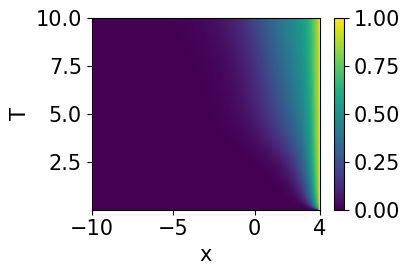

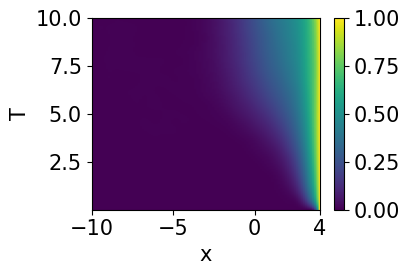

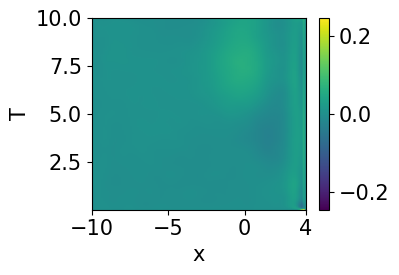

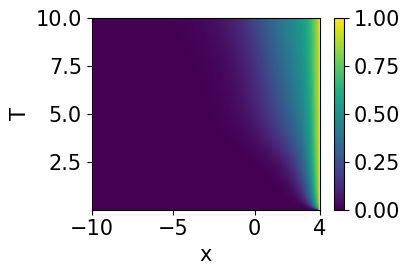

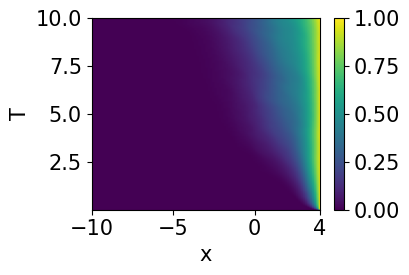

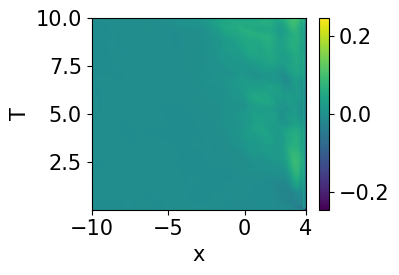

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------
# Assumptions: The following functions are defined:
# - generate_drift(T_vals, T)
# - ground_truth(x_vals, T_vals, a, u)
# - BsKnots(n_cp, d, Ns)
# And the trained models neso_model and fno_model are loaded.
# ---------------------------------------------------

# Set a very large global font size
plt.rcParams.update({'font.size': 15})

# ---------------------------
# Parameters and Grids
# ---------------------------
T = 10.0        # maximum time
a = 4.0         # barrier value
n_cp_t = 25     # number of control points in time
n_cp_x = 25     # number of control points in space
d = 3           # B-spline order

# Define refined time grid and spatial grid
T_vals = np.linspace(1e-4, T, 1001)  # 1001 time points from 1e-4 to T
Nt = len(T_vals)
x_vals = np.linspace(-10, a, 101)      # 101 spatial points from -10 to a
Nx = len(x_vals)

# ---------------------------
# Compute B-spline Bases
# ---------------------------
# Compute B-spline basis for time (shared across samples)
tk_t, Ln_t, Bit_t_np = BsKnots(n_cp_t, d, Nt)
Bit_t = torch.tensor(Bit_t_np, dtype=torch.float32)

# Compute B-spline basis for space
tk_x, Ln_x, Bit_x_np = BsKnots(n_cp_x, d, Nx)
Bit_x = torch.tensor(Bit_x_np, dtype=torch.float32)

# ---------------------------
# Generate a Common Test Sample
# ---------------------------
u_test = generate_drift(T_vals, T)
F_true_test = ground_truth(x_vals, T_vals, a, u_test)  # shape: (Nt, Nx)

# ---------------------------
# Testing with NeSO (Proposed Method)
# ---------------------------
# Prepare input for NeSO (expected shape: (1, 1, Nt, Nx))
F_true_tensor = torch.tensor(F_true_test, dtype=torch.float32)
F_input = F_true_tensor.unsqueeze(0).unsqueeze(0)

neso_model.eval()
with torch.no_grad():
    # Model returns inner control points with shape (n_cp_t-1, n_cp_x-1)
    U_pred = neso_model(F_input)[0]

# Construct full control points with boundary conditions:
# - At t = 0, set all control points to 0.
# - At x = a, set all control points to 1.
U_full = torch.ones((n_cp_t, n_cp_x))
U_full[0, :] = 0
U_full[:, -1] = 1
U_full[1:, :-1] = U_pred

# Compute predicted B-spline surface (hitting probability)
B_surface = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x.T)
F_pred_neso = B_surface.detach().numpy()

# ---------------------------
# Testing with FNO
# ---------------------------
# Prepare input tensor for FNO with shape (1, 3, Nt, Nx)
# Channel 0: u_test broadcast to (Nt, Nx)
u_tensor = torch.tensor(u_test, dtype=torch.float32).unsqueeze(1).repeat(1, Nx)
# Channel 1: time coordinate (Nt, Nx)
t_tensor = torch.tensor(T_vals, dtype=torch.float32).unsqueeze(1).repeat(1, Nx)
# Channel 2: spatial coordinate (Nt, Nx)
x_tensor = torch.tensor(x_vals, dtype=torch.float32).unsqueeze(0).repeat(Nt, 1)
input_tensor = torch.stack([u_tensor, t_tensor, x_tensor], dim=0).unsqueeze(0)

fno_model.eval()
with torch.no_grad():
    F_pred_fno = fno_model(input_tensor).squeeze().cpu().numpy()

# ---------------------------
# Compute Common Error Range for Both Methods
# ---------------------------
error_neso = F_pred_neso - F_true_test
error_fno  = F_pred_fno - F_true_test
E = max(np.abs(error_neso).max(), np.abs(error_fno).max())
error_range = (-E/2, E/2)

# ---------------------------
# Visualization Helper Function
# ---------------------------
def plot_and_save(image, vmin, vmax, filename):
    """
    Plots the given image with fixed color limits and saves the plot as a PDF.
    The plot uses the x-axis from -10 to 4 (ensuring 4 is included) and
    labels the vertical axis as 'T'.
    """
    fig, ax = plt.subplots(figsize=(4, 3))
    im = ax.imshow(image, aspect='auto', origin='lower',
                   extent=[x_vals[0], x_vals[-1], T_vals[0], T_vals[-1]],
                   vmin=vmin, vmax=vmax)
    ax.set_xlabel("x")
    ax.set_ylabel("T")
    ax.set_xlim(x_vals[0], x_vals[-1])
    ax.set_xticks([-10, -5, 0, 4])
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.savefig(filename, format="pdf")
    plt.show()
    plt.close(fig)

# ---------------------------
# Save Individual Plots as PDF Files
# ---------------------------
# For NeSO (Proposed Method)
plot_and_save(F_true_test, 0, 1, "NeSO_GroundTruth.pdf")
plot_and_save(F_pred_neso, 0, 1, "NeSO_Prediction.pdf")
plot_and_save(F_pred_neso - F_true_test, error_range[0], error_range[1], "NeSO_Error.pdf")

# For FNO
plot_and_save(F_true_test, 0, 1, "FNO_GroundTruth.pdf")
plot_and_save(F_pred_fno, 0, 1, "FNO_Prediction.pdf")
plot_and_save(F_pred_fno - F_true_test, error_range[0], error_range[1], "FNO_Error.pdf")


Error Analysis

In [ ]:
import torch
import numpy as np

# ---------------------------
# Parameters and Grids
# ---------------------------
T = 10.0        # maximum time
a = 4.0         # barrier value
n_cp_t = 25     # number of control points in time
n_cp_x = 25     # number of control points in space
d = 3           # B-spline order

# Define refined time grid and spatial grid
T_vals = np.linspace(1e-4, T, 1001)  # 1001 time points from 1e-4 to T
Nt = len(T_vals)
x_vals = np.linspace(-10, a, 101)      # 101 spatial points from -10 to a
Nx = len(x_vals)

# ---------------------------
# Compute B-spline Bases
# ---------------------------
# Compute B-spline basis for time (shared across samples)
tk_t, Ln_t, Bit_t_np = BsKnots(n_cp_t, d, Nt)
Bit_t = torch.tensor(Bit_t_np, dtype=torch.float32)

# Compute B-spline basis for space
tk_x, Ln_x, Bit_x_np = BsKnots(n_cp_x, d, Nx)
Bit_x = torch.tensor(Bit_x_np, dtype=torch.float32)

# ---------------------------
# Containers for Error Metrics
# ---------------------------
neso_mse_list = []
neso_mae_list = []
neso_rel_list = []
fno_mse_list = []
fno_mae_list = []
fno_rel_list = []

num_test_cases = 10

for i in range(num_test_cases):
    # ---------------------------
    # Generate Test Data for Test Case i
    # ---------------------------
    u_test = generate_drift(T_vals, T)
    F_true_test = ground_truth(x_vals, T_vals, a, u_test)  # shape: (Nt, Nx)

    # ---------------------------
    # NeSO Prediction
    # ---------------------------
    F_true_tensor = torch.tensor(F_true_test, dtype=torch.float32)
    F_input = F_true_tensor.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, Nt, Nx)
    neso_model.eval()
    with torch.no_grad():
        # Model returns inner control points with shape (n_cp_t-1, n_cp_x-1)
        U_pred = neso_model(F_input)[0]

    # Construct full control points with boundary conditions:
    # - At t = 0, set all control points to 0.
    # - At x = a, set all control points to 1.
    U_full = torch.ones((n_cp_t, n_cp_x))
    U_full[0, :] = 0
    U_full[:, -1] = 1
    U_full[1:, :-1] = U_pred

    # Compute predicted B-spline surface (hitting probability)
    B_surface = torch.matmul(torch.matmul(Bit_t, U_full), Bit_x.T)
    F_pred_neso = B_surface.detach().numpy()

    # ---------------------------
    # FNO Prediction
    # ---------------------------
    # Prepare input tensor for FNO with shape (1, 3, Nt, Nx)
    # Channel 0: u_test broadcast to (Nt, Nx)
    u_tensor = torch.tensor(u_test, dtype=torch.float32).unsqueeze(1).repeat(1, Nx)
    # Channel 1: time coordinate (Nt, Nx)
    t_tensor = torch.tensor(T_vals, dtype=torch.float32).unsqueeze(1).repeat(1, Nx)
    # Channel 2: spatial coordinate (Nt, Nx)
    x_tensor = torch.tensor(x_vals, dtype=torch.float32).unsqueeze(0).repeat(Nt, 1)
    input_tensor = torch.stack([u_tensor, t_tensor, x_tensor], dim=0).unsqueeze(0)

    fno_model.eval()
    with torch.no_grad():
        F_pred_fno = fno_model(input_tensor).squeeze().cpu().numpy()

    # ---------------------------
    # Compute Errors for Test Case i
    # ---------------------------
    error_neso = F_pred_neso - F_true_test
    error_fno = F_pred_fno - F_true_test

    mse_neso = np.mean(error_neso**2)
    mae_neso = np.mean(np.abs(error_neso))
    # Relative error: using Frobenius norm for 2D arrays
    rel_neso = np.linalg.norm(error_neso) / np.linalg.norm(F_true_test)

    mse_fno = np.mean(error_fno**2)
    mae_fno = np.mean(np.abs(error_fno))
    rel_fno = np.linalg.norm(error_fno) / np.linalg.norm(F_true_test)

    neso_mse_list.append(mse_neso)
    neso_mae_list.append(mae_neso)
    neso_rel_list.append(rel_neso)
    fno_mse_list.append(mse_fno)
    fno_mae_list.append(mae_fno)
    fno_rel_list.append(rel_fno)

# ---------------------------
# Compute and Report Averaged Metrics
# ---------------------------
neso_mse_avg = np.mean(neso_mse_list)
neso_mae_avg = np.mean(neso_mae_list)
neso_rel_avg = np.mean(neso_rel_list)

fno_mse_avg = np.mean(fno_mse_list)
fno_mae_avg = np.mean(fno_mae_list)
fno_rel_avg = np.mean(fno_rel_list)

print("NeSO Metrics (averaged over 10 test cases):")
print("Mean Squared Error:", neso_mse_avg)
print("Mean Absolute Error:", neso_mae_avg)
print("Relative Error:", neso_rel_avg)
print("\nFNO Metrics (averaged over 10 test cases):")
print("Mean Squared Error:", fno_mse_avg)
print("Mean Absolute Error:", fno_mae_avg)
print("Relative Error:", fno_rel_avg)


NeSO Metrics (averaged over 10 test cases):
Mean Squared Error: 0.00043690114450564986
Mean Absolute Error: 0.011318588038866527
Relative Error: 0.08093221896481802

FNO Metrics (averaged over 10 test cases):
Mean Squared Error: 0.002454459204915527
Mean Absolute Error: 0.02285355321931521
Relative Error: 0.14944131143277378
